## W207 Final Project: Predicting Song Success

Instructor: Cornelia Ilin <br>
Team Members: Tyler Chi, Raghav Kaushik, Michael Townsend

---
#### ``Baseline Presentation:``
**1.  What is the question you will be working on? Why is it interesting?** <br>
The question we will be working on is identifying what traits make a song stay on top 200 charts the longest?  Given a set of known features about a song, can we predict if it will land on the top 200 and if so for how long?  This question is interesting because artists could potentially use it to determine the style of songs to write and when to come out with those songs for the highest success.  Factors to study could include Day of the Week, Time of Year (Season), Spotify Song Features, & Artist # of Followers. <br>

**2.  What is the data you will be using? Include data source, size of dataset, main features to be used. Summarize the statistics of your data.** <br>
The data we will be using is Spotify data from 2017 to 2020 from 2 sources on Kaggle:

Spotify Charts: https://www.kaggle.com/datasets/dhruvildave/spotify-charts 
Spotify Artists/Tracks: https://www.kaggle.com/datasets/yamaerenay/spotify-dataset-19212020-600k-tracks?select=tracks.csv 

Three Primary Data Sets from these sources:

artists.csv: 1162095 rows, Main Features to be used --> artist name, popularity, and number of followers.  We'd use this file to merge the Artist # of Followers onto the Song Dataset using Artist name to add that metric to our analysis.

charts.csv: 26173514 rows. Main Features to be used --> Date, # of Streams on Top 200, Chart Rank, Time on Chart.  We'd use this file to label the success of each song we study.  

tracks.csv: 586672 rows. this has information that Spotify generated, characterizing various songs with continuous data (loudness, energy, danceability), as well as some discrete data (key, time_signature). To make this data easier to use in our models, we will apply Standardization to all of the continuous parameters.  For the discrete data we will create one-hot encodings.

<br>

**3.  What prediction algorithms do you plan to use? Please describe them in detail.** <br>
We plan to try a mix of classification & regression models to approach this problem.

First, we will use a Feedforward Neural Network to predict whether any song coming out between 2017 and 2021 will land on the top 200.

Second, we will use the data that does hit the top 200 and predict using linear regression & gradient descent how many streams a given song will have while on the top 200.

This will give the artist a way to predict not only what features it takes to get on the chart, but also how to stay on the chart and reach a platinum record status.

For our baseline models we will use just use the Artist # of Followers:

- Artist # of Followers

For our full models we will use the Artist # of Followers along w/ time features along and the Spotify Song Features:

- Artist # of Followers
- Date of Release
- Day of Week of Release
- Time of Year (Season) of Release
- *12 Song Features:* Duration, Danceability, Energy, Loudness, Key, Speechiness, Acoustiness, Instrumentalness, Liveness, Valence, Tempo, Time Signature

Since some of our data is time-based, we plan to perform a non-random split between train and test sets in order to make sure our model is predictive of new data.

The success metrics we will be predicting for the two models will be:

1. Binary Classification --> Top 200 or not?
2. Regression --> # of Streams on Top 200 Charts within X weeks/months of release
<br>

**4. How will you evaluate your results? Please describe your chosen performance metrices and/or statistical tests in detail.** <br>

To evaluate our first Model (Classification using a Feed-Forward Nueral Network) we will use the following:

- Loss, Accuracy, Precision, Recall, Sensitivity, Specificity, F1 Score

We plan to test out different combinations of layers in our neural net (using Keras/Tensorflow) to optimize accuracy on the test dataset.  We'll also assess the other metrics that are typically assessed when evaluating a classification problem.

To evaluate our second Model (Linear Regression) we will use the following:

- Mean Squared Error, R Squared

We plan to use Keras/Tensorflow and run the model at different learning rates to find the optimal mean squared error.

We plan to make comparisons of our baseline model vs. our optimized model for each of the 4 seasons to see if the additional features from the song & time of year make the model more predictive than just using the artist # of followers alone. <br>

In [150]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import pyspark.sql.types as t
import pyspark.sql.functions as f
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from datetime import datetime
from datetime import date, timedelta
import numpy as np

In [151]:
# import dataframe
df = pd.read_csv('~/W207/W207_Final_Project/Spotify_Charts/charts.csv')

In [152]:
df.columns

Index(['title', 'rank', 'date', 'artist', 'url', 'region', 'chart', 'trend',
       'streams'],
      dtype='object')

In [153]:
df.head(5)

,title,rank,date,artist,url,region,chart,trend,streams
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,Argentina,top200,SAME_POSITION,253019.0
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,https://open.spotify.com/track/7DM4BPaS7uofFul...,Argentina,top200,MOVE_UP,223988.0
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,https://open.spotify.com/track/3AEZUABDXNtecAO...,Argentina,top200,MOVE_DOWN,210943.0
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",https://open.spotify.com/track/6rQSrBHf7HlZjtc...,Argentina,top200,SAME_POSITION,173865.0
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,https://open.spotify.com/track/58IL315gMSTD37D...,Argentina,top200,MOVE_UP,153956.0


In [154]:
df2 = pd.read_csv('~/W207/W207_Final_Project/Spotify_Tracks/artists.csv')
df3 = pd.read_csv('~/W207/W207_Final_Project/Spotify_Tracks/tracks.csv')

In [155]:
fav_artists = df2.query('name == "Ed Sheeran" | name == "Ben Platt" | name == "Josh Groban" | name == "Dave Matthews"')
fav_artists.head(5)

,id,followers,genres,name,popularity
100018,13vQloYd6mP7V1mVwKJwS2,278606.0,['pop rock'],Dave Matthews,57
143754,6cXMpsP9x0SH4kFfMyVezF,671658.0,"['adult standards', 'operatic pop']",Josh Groban,65
144138,6eUKZXaKkcviH0Ku9w2n3V,78900234.0,"['pop', 'uk pop']",Ed Sheeran,92
213007,6qGkLCMQkNGOJ079iEcC5k,356372.0,"['hollywood', 'pop', 'post-teen pop', 'show tu...",Ben Platt,71


In [156]:
df3.head(10)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.744000,0.1510,0.1270,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.000000,0.1480,0.6550,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.021800,0.2120,0.4570,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.918000,0.1040,0.3970,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.130000,0.3110,0.1960,103.220,4
5,0BRXJHRNGQ3W4v9frnSfhu,Ave Maria,0,178933,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.227,0.2610,5,-12.343,1,0.0382,0.994,0.247000,0.0977,0.0539,118.891,4
6,0Dd9ImXtAtGwsmsAD69KZT,La Butte Rouge,0,134467,0,['Francis Marty'],['2nuMRGzeJ5jJEKlfS7rZ0W'],1922,0.510,0.3550,4,-12.833,1,0.1240,0.965,0.000000,0.1550,0.7270,85.754,5
7,0IA0Hju8CAgYfV1hwhidBH,La Java,0,161427,0,['Mistinguett'],['4AxgXfD7ISvJSTObqm4aIE'],1922,0.563,0.1840,4,-13.757,1,0.0512,0.993,0.000016,0.3250,0.6540,133.088,3
8,0IgI1UCz84pYeVetnl1lGP,Old Fashioned Girl,0,310073,0,['Greg Fieler'],['5nWlsH5RDgFuRAiDeOFVmf'],1922,0.488,0.4750,0,-16.222,0,0.0399,0.620,0.006450,0.1070,0.5440,139.952,4
9,0JV4iqw2lSKJaHBQZ0e5zK,Martín Fierro - Remasterizado,0,181173,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-29,0.548,0.0391,6,-23.228,1,0.1530,0.996,0.933000,0.1480,0.6120,75.595,3


In [173]:
## Parse Tracks file down to last 3 years
df3['release_date'] = pd.to_datetime(df3['release_date'])
recent_tracks_df = df3.query('release_date >= "2017-01-01" & release_date < "2021-01-01"')

## Filter Charts file down to US and Top 200
top_200_charts = df.query('chart == "top200" & region == "Global"')

In [174]:
top_200_charts['track_id'] = top_200_charts.url.apply(lambda x: x.split('/')[-1])

<ipython-input-174-740ef97a603e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_200_charts['track_id'] = top_200_charts.url.apply(lambda x: x.split('/')[-1])


In [175]:
top_200_track_id_set = set()
for track_id in top_200_charts['track_id'].values:
    top_200_track_id_set.add(track_id)

In [176]:
# determine if a song has appeared in the top 200s
def get_top_200_presence(row):
    track_id = row['id']
    return bool(track_id in top_200_track_id_set)

In [177]:
recent_tracks_df['top_200_presence'] = recent_tracks_df.apply(get_top_200_presence, axis=1)

<ipython-input-177-c15da4de460f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_tracks_df['top_200_presence'] = recent_tracks_df.apply(get_top_200_presence, axis=1)


In [178]:
# map of artist id to followers
artist_id_to_followers = pd.Series(df2.followers.values, index=df2.id)

In [179]:
# helper method to get number of followers by artist.
def get_followers_by_id_artist(id_artist):
    if id_artist in artist_id_to_followers:
        return artist_id_to_followers[id_artist]
    return 0

In [180]:
# takes the raw id_artists column, like "['6s1pCNXcbdtQJlsnM1hRIA', '2qGkessPTMJjSEYtxJ11KC', '3rZueITwheLTXxo6uKMdRn']"
# parses out the id's, and returns the total number of followers
def get_total_followers(row):
    id_artist_str = row["id_artists"]
    total_followers = 0
    id_artist_list = id_artist_str[1:-1].replace("'","").replace(" ", "").split(",")
    for id_artist in id_artist_list:
        total_followers += get_followers_by_id_artist(id_artist)
    return total_followers

<ipython-input-181-99a6a641355e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_tracks_df['total_follower_count'] = recent_tracks_df.apply(get_total_followers, axis=1)


<AxesSubplot:>

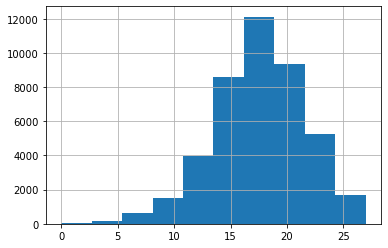

In [181]:
recent_tracks_df['total_follower_count'] = recent_tracks_df.apply(get_total_followers, axis=1)
recent_tracks_df = recent_tracks_df.query('total_follower_count > 0')
recent_tracks_df['log_total_follower_count'] = np.log2(recent_tracks_df['total_follower_count'])
recent_tracks_df['log_total_follower_count'].hist()

In [182]:
recent_tracks_df['top_200_presence'].value_counts()

False    41021
True      2305
Name: top_200_presence, dtype: int64

In [183]:
## Merge release_date into charts_df using track_id

recent_tracks_df_merging = recent_tracks_df[['id', 'release_date']]

merge_rel_date = pd.merge(top_200_charts, recent_tracks_df_merging, left_on='track_id', right_on='id')

merge_rel_date['date'] = pd.to_datetime(merge_rel_date['date'])
merge_rel_date['release_date'] = pd.to_datetime(merge_rel_date['release_date'])

merge_rel_date['days_since_release'] = ((merge_rel_date['date'] - merge_rel_date['release_date']) / np.timedelta64(1,'m'))/1440

print(len(merge_rel_date))

merge_rel_date = merge_rel_date.query('days_since_release > 0')

print(len(merge_rel_date))

charts_within_30_days_of_release = merge_rel_date.query('days_since_release <= 30')
print(len(charts_within_30_days_of_release))

Num_streams_by_ID = charts_within_30_days_of_release.groupby('track_id', as_index=False)['streams'].sum()
print(len(Num_streams_by_ID))

recent_tracks_df_w_streams = pd.merge(recent_tracks_df, Num_streams_by_ID, left_on='id', right_on='track_id')

recent_tracks_df_w_streams['log_artist_streams'] = np.log2(recent_tracks_df_w_streams['streams'])

top_200_recent_tracks_only = recent_tracks_df_w_streams.query('streams > 0')

212983
209863
32460
1790


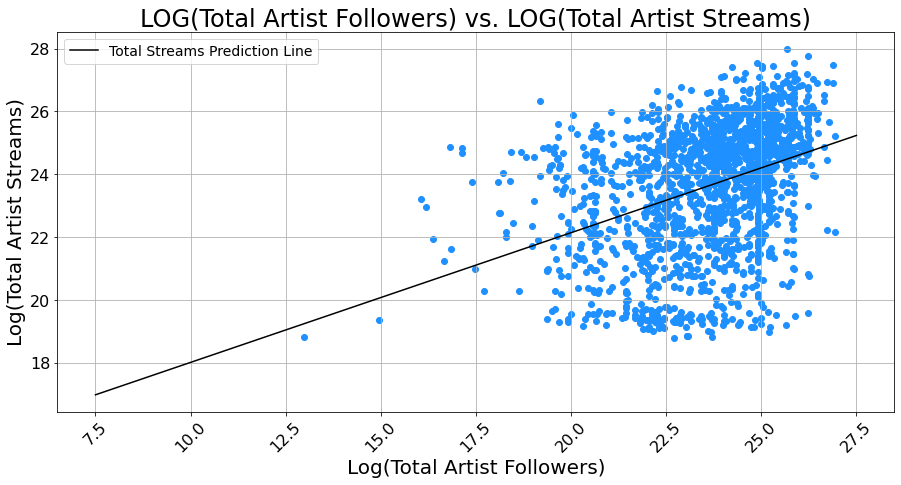

In [190]:
#a method that lets us make a polynomial model:
regression_line = np.poly1d(np.polyfit(top_200_recent_tracks_only['log_total_follower_count'],top_200_recent_tracks_only['log_artist_streams'],1))
#Then specify how the line will display, we start 
#at position 1, and end at position 22
line_streams = np.linspace(7.5, 27.5)


plt.figure(figsize=(15,7))
plt.scatter(top_200_recent_tracks_only['log_total_follower_count'], top_200_recent_tracks_only['log_artist_streams'], color='dodgerblue')
plt.plot(line_streams, regression_line(line_streams), color = 'black', label = 'Total Streams Prediction Line')
plt.title('LOG(Total Artist Followers) vs. LOG(Total Artist Streams)', fontsize=24)
plt.xlabel('Log(Total Artist Followers)', fontsize=20)
plt.ylabel('Log(Total Artist Streams)', fontsize=20)
plt.legend(fontsize=14)
plt.xticks(fontsize=16, rotation = 45)
plt.yticks(fontsize=16, rotation = 0)
plt.grid()
plt.show()

In [187]:
outliers = top_200_recent_tracks_only.query('log_total_follower_count < 17.5')
outliers = outliers.sort_values('log_total_follower_count')
outliers[['name', 'artists', 'release_date', 'total_follower_count', 'log_total_follower_count', 'streams', 'log_artist_streams']]

,name,artists,release_date,total_follower_count,log_total_follower_count,streams,log_artist_streams
133,Tightrope,['Michelle Williams'],2017-12-08,8116.0,12.986553,461277.0,18.815274
1502,Tigers,['Bilal Wahib'],2020-06-18,31905.0,14.961495,668024.0,19.349540
1282,Stunnin' (feat. Harm Franklin),"['Curtis Waters', 'Harm Franklin']",2020-10-09,67951.0,16.052207,9816044.0,23.226710
694,Si Me Tomo Una Cerveza,"['Migrantes', 'Alico']",2020-11-07,74422.0,16.183442,8087270.0,22.947221
47,Never Enough,['Loren Allred'],2017-12-08,84376.0,16.364545,4050416.0,21.949639
1545,Fai rumore,['Diodato'],2020-02-05,103697.0,16.662015,2495075.0,21.250652
1006,Tak Tiki Tak,['Harry Nach'],2020-07-10,115912.0,16.822670,30308044.0,24.853197
587,The Git Up,['Blanco Brown'],2019-10-10,118122.0,16.849918,3190465.0,21.605335
733,Party Girl,['StaySolidRocky'],2020-04-21,144594.0,17.141648,27012409.0,24.687119
1276,Party Girl,['StaySolidRocky'],2020-07-15,144594.0,17.141648,29715926.0,24.824733


In [188]:
top_200_recent_tracks_only = top_200_recent_tracks_only.sort_values('log_artist_streams', ascending=False)
top_200_recent_tracks_only.head(5)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,top_200_presence,total_follower_count,log_total_follower_count,track_id,streams,log_artist_streams
399,0TK2YIli7K1leLovkQiNik,Señorita,84,190960,0,"['Shawn Mendes', 'Camila Cabello']","['7n2wHs1TKAczGzO7Dd2rGr', '4nDoRrQiYLoBzwC5Bh...",2019-06-21,0.759,0.540,9,-6.039,0,0.0287,0.03700,0.000000,0.0945,0.750,116.947,4,True,53499792.0,25.673030,0TK2YIli7K1leLovkQiNik,266964697.0,27.992074
2,7qiZfU4dY1lWllzX7mPBI3,Shape of You,87,233713,0,['Ed Sheeran'],['6eUKZXaKkcviH0Ku9w2n3V'],2017-03-03,0.825,0.652,1,-3.183,0,0.0802,0.58100,0.000000,0.0931,0.931,95.977,4,True,78900234.0,26.233526,7qiZfU4dY1lWllzX7mPBI3,227628378.0,27.762105
386,6ocbgoVGwYJhOv1GgI9NsF,7 rings,87,178627,1,['Ariana Grande'],['66CXWjxzNUsdJxJ2JdwvnR'],2019-02-08,0.778,0.317,1,-10.732,0,0.3340,0.59200,0.000000,0.0881,0.327,140.048,4,True,61301006.0,25.869407,6ocbgoVGwYJhOv1GgI9NsF,195379150.0,27.541701
603,0VjIjW4GlUZAMYd2vXMi3b,Blinding Lights,96,200040,0,['The Weeknd'],['1Xyo4u8uXC1ZmMpatF05PJ'],2020-03-20,0.514,0.730,1,-5.934,1,0.0598,0.00146,0.000095,0.0897,0.334,171.005,4,True,31308207.0,24.900038,0VjIjW4GlUZAMYd2vXMi3b,193821742.0,27.530155
409,3HVWdVOQ0ZA45FuZGSfvns,I Don't Care (with Justin Bieber),83,219947,0,"['Ed Sheeran', 'Justin Bieber']","['6eUKZXaKkcviH0Ku9w2n3V', '1uNFoZAHBGtllmzznp...",2019-05-10,0.798,0.675,6,-5.041,1,0.0442,0.09120,0.000000,0.0894,0.842,101.956,4,True,123507207.0,26.880020,3HVWdVOQ0ZA45FuZGSfvns,187576778.0,27.482906


In [189]:
print('Length of Top 200 Prediction Dataset - ' + str(len(recent_tracks_df)))
print('Length of # of Streams on Top 200 in first month - ' + str(len(top_200_recent_tracks_only)))

Length of Top 200 Prediction Dataset - 43326
Length of # of Streams on Top 200 in first month - 1790


In [191]:
## Saving sets we will use for our Analysis
recent_tracks_df.to_csv('Top_200_Binary_Classification_Dataset.csv', index=None)
top_200_recent_tracks_only.to_csv('Top_200_Stream_Count_Regression_Dataset.csv', index=None)

In [192]:
recent_tracks_df.columns

Index(['id', 'name', 'popularity', 'duration_ms', 'explicit', 'artists',
       'id_artists', 'release_date', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature', 'top_200_presence',
       'total_follower_count', 'log_total_follower_count'],
      dtype='object')

In [193]:
recent_tracks_df.head(1)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,top_200_presence,total_follower_count,log_total_follower_count
39529,1hx7X9cMXHWJjknb9O6Ava,The September Of My Years - Live At The Sands ...,26,187333,0,['Frank Sinatra'],['1Mxqyy3pSjf8kZZL4QVxS0'],2018-05-04,0.319,0.201,7,-17.796,1,0.0623,0.887,0.0,0.904,0.239,117.153,3,False,4677919.0,22.157435


---
#### ``Data Pre-Processing:``
**One-Hot Encodings** <br>
- Key
- Time Signature
- Month
- Day of Week
- Year

**Fix Class Imbalance** <br>
- Choose 2300 random samples from True & False Population

**Split into Training & Test Sets** <br>
- 70 / 30 Split

**Apply Standardization to Features** <br>
- Number of Artist Followers
- Danceability
- Energy
- Loudness
- Speechiness
- Acousticness
- Instrumentalness
- Liveness
- Valance
- Tempo

#### ``One-Hot Encodings``

In [194]:
recent_tracks_df['release_date'] = pd.to_datetime(recent_tracks_df['release_date'])
recent_tracks_df['month_of_release'] = pd.DatetimeIndex(recent_tracks_df['release_date']).month
recent_tracks_df['year_of_release'] = pd.DatetimeIndex(recent_tracks_df['release_date']).year
recent_tracks_df['day_of_week_release'] = pd.DatetimeIndex(recent_tracks_df['release_date']).dayofweek

In [195]:
recent_tracks_df['key'].unique()

array([ 7, 11,  1,  6, 10,  2,  9,  8,  0,  5,  4,  3], dtype=int64)

In [196]:
recent_tracks_df['time_signature'].unique()

array([3, 4, 1, 5, 0], dtype=int64)

In [200]:
recent_tracks_df['day_of_week_release'].unique()

array([4, 3, 2, 1, 5, 6, 0], dtype=int64)

In [197]:
## create one-hot-encodings ##
##############################

# for year
years = ['2017', '2018', '2019', '2020']
y_d = pd.get_dummies(
    recent_tracks_df['year_of_release'],
    prefix='',
    prefix_sep='',
    drop_first = False
) 
y_d = y_d.T.reindex(years).T.fillna(0)

# for months
months = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
m_d = pd.get_dummies(
    recent_tracks_df['month_of_release'],
    prefix='',
    prefix_sep='',
    drop_first = False
) 
m_d = m_d.T.reindex(months).T.fillna(0)

# join one-hot-encodings
dummies = y_d.join(m_d)

# add to initial df
recent_tracks_df = pd.concat(
    [recent_tracks_df, dummies],
    axis=1
)

In [199]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
recent_tracks_df.rename(columns = {'1':'m1', '2':'m2', '3':'m3', '4':'m4', '5':'m5', '6':'m6', '7':'m7', '8':'m8', '9':'m9', '10':'m10', '11':'m11', '12':'m12'}, inplace = True)
recent_tracks_df.head(1)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,top_200_presence,total_follower_count,log_total_follower_count,month_of_release,year_of_release,day_of_week_release,2017,2018,2019,2020,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
39529,1hx7X9cMXHWJjknb9O6Ava,The September Of My Years - Live At The Sands ...,26,187333,0,['Frank Sinatra'],['1Mxqyy3pSjf8kZZL4QVxS0'],2018-05-04,0.319,0.201,7,-17.796,1,0.0623,0.887,0.0,0.904,0.239,117.153,3,False,4677919.0,22.157435,5,2018,4,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [201]:
## create one-hot-encodings ##
##############################

# for day of week
days = ['1', '2', '3', '4', '5', '6'] #dropped the first day == "0" (as a result, you don't need an intercept in the model)
doy_of_w_d = pd.get_dummies(
    recent_tracks_df['day_of_week_release'],
    prefix='',
    prefix_sep='',
    drop_first = True
) 
dummies = doy_of_w_d.T.reindex(days).T.fillna(0)

# add to initial df
recent_tracks_df = pd.concat(
    [recent_tracks_df, dummies],
    axis=1
)

In [203]:
recent_tracks_df.rename(columns = {'1':'d1', '2':'d2', '3':'d3', '4':'d4', '5':'d5', '6':'d6'}, inplace = True)
recent_tracks_df.head(1)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,top_200_presence,total_follower_count,log_total_follower_count,month_of_release,year_of_release,day_of_week_release,2017,2018,2019,2020,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,d1,d2,d3,d4,d5,d6
39529,1hx7X9cMXHWJjknb9O6Ava,The September Of My Years - Live At The Sands ...,26,187333,0,['Frank Sinatra'],['1Mxqyy3pSjf8kZZL4QVxS0'],2018-05-04,0.319,0.201,7,-17.796,1,0.0623,0.887,0.0,0.904,0.239,117.153,3,False,4677919.0,22.157435,5,2018,4,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [204]:
## create one-hot-encodings ##
##############################

# for key
keys = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'] #dropped the first key == "0" (as a result, you don't need an intercept in the model)
key_d = pd.get_dummies(
    recent_tracks_df['key'],
    prefix='',
    prefix_sep='',
    drop_first = True
) 
dummies = key_d.T.reindex(keys).T.fillna(0)

# add to initial df
recent_tracks_df = pd.concat(
    [recent_tracks_df, dummies],
    axis=1
)

In [206]:
recent_tracks_df.rename(columns = {'1':'k1', '2':'k2', '3':'k3', '4':'k4', '5':'k5', '6':'k6', '7':'k7', '8':'k8', '9':'k9', '10':'k10', '11':'k11'}, inplace = True)
recent_tracks_df.head(1)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,top_200_presence,total_follower_count,log_total_follower_count,month_of_release,year_of_release,day_of_week_release,2017,2018,2019,2020,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,d1,d2,d3,d4,d5,d6,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11
39529,1hx7X9cMXHWJjknb9O6Ava,The September Of My Years - Live At The Sands ...,26,187333,0,['Frank Sinatra'],['1Mxqyy3pSjf8kZZL4QVxS0'],2018-05-04,0.319,0.201,7,-17.796,1,0.0623,0.887,0.0,0.904,0.239,117.153,3,False,4677919.0,22.157435,5,2018,4,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


In [207]:
## create one-hot-encodings ##
##############################

# for time_signature
times = ['1', '2', '3', '4', '5'] #dropped the first key == "0" (as a result, you don't need an intercept in the model)
time_d = pd.get_dummies(
    recent_tracks_df['time_signature'],
    prefix='',
    prefix_sep='',
    drop_first = True
) 
dummies = time_d.T.reindex(times).T.fillna(0)

# add to initial df
recent_tracks_df = pd.concat(
    [recent_tracks_df, dummies],
    axis=1
)

In [208]:
recent_tracks_df.rename(columns = {'1':'t1', '2':'t2', '3':'t3', '4':'t4', '5':'t5'}, inplace = True)
recent_tracks_df.head(1)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,top_200_presence,total_follower_count,log_total_follower_count,month_of_release,year_of_release,day_of_week_release,2017,2018,2019,2020,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,d1,d2,d3,d4,d5,d6,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,t1,t2,t3,t4,t5
39529,1hx7X9cMXHWJjknb9O6Ava,The September Of My Years - Live At The Sands ...,26,187333,0,['Frank Sinatra'],['1Mxqyy3pSjf8kZZL4QVxS0'],2018-05-04,0.319,0.201,7,-17.796,1,0.0623,0.887,0.0,0.904,0.239,117.153,3,False,4677919.0,22.157435,5,2018,4,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0.0,1.0,0.0,0.0


#### ``Balance Dataset``

Our dataset is very imbalanced. We will correct for class imbalance by taking only 46,000 random examples from each class.

In [212]:
# randomly draw 2300 examples from each class
temp_false = recent_tracks_df[recent_tracks_df['top_200_presence'] == False].sample(
    n=2300,
    replace=False
)

temp_true = recent_tracks_df[recent_tracks_df['top_200_presence'] == True].sample(
    n=2300,
    replace=False
)

df_balanced = pd.concat(
    [temp_false, temp_true],
    axis=0)

# shuffle df_balanced
df_balanced.sample(frac=1) # frac=1 retains all the data
df_balanced.reset_index(drop=True, inplace=True) # reset index

print('After preprocessing, our data contains', df_balanced.shape[0], 'songs')

After preprocessing, our data contains 4600 songs


In [213]:
df_balanced['top_200_presence'].value_counts()

True     2300
False    2300
Name: top_200_presence, dtype: int64

In [216]:
df_balanced['top_200_binary'] = np.where(df_balanced['top_200_presence'] == True, 1, 0)
df_balanced.head(5)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,top_200_presence,total_follower_count,log_total_follower_count,month_of_release,year_of_release,day_of_week_release,2017,2018,2019,2020,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,d1,d2,d3,d4,d5,d6,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,t1,t2,t3,t4,t5,top_200_binary
0,7eM5THaTwZGC82TkPiFs40,пластинки,59,184509,0,['Дурной Вкус'],['75hHfYoo9WURXtqGB24Q2j'],2018-10-05,0.496,0.914,2,-6.368,0,0.0351,0.0963,0.765000,0.0850,0.723,172.965,4,False,18686.0,14.189670,10,2018,4,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0
1,3DiMzwiBQkqE0k4qt7Lgsd,星期三或禮拜三,46,261600,0,"['Waa Wei', 'Di Ma']","['190bkHbFrRvEhcB7Zpuv3y', '6INLZbPHXGj6ERrjFG...",2019-11-20,0.391,0.313,10,-11.832,1,0.0576,0.7600,0.000001,0.1400,0.154,140.002,4,False,149628.0,17.191021,11,2019,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0.0,1.0,0.0,0
2,4pmbb2QmCMrfNT9kL0nVtG,mailbox,62,174500,0,"['Dardan', 'Hava']","['3pjq2pDV9RR6VY55wBjVnp', '3Mn6d673ieRza7uw6z...",2020-10-02,0.578,0.655,1,-6.704,0,0.0571,0.3510,0.000009,0.1750,0.440,124.846,4,False,990435.0,19.917703,10,2020,4,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0
3,6sgqf4wXFWSAmjL1TEXNvZ,Something About You (with Rudimental) - Chill Mix,69,166534,0,"['Elderbrook', 'Rudimental']","['2vf4pRsEY6LpL5tKmqWb64', '4WN5naL3ofxrVBgFpg...",2019-10-04,0.800,0.516,6,-8.076,0,0.1270,0.3650,0.002060,0.1340,0.443,106.122,4,False,1466244.0,20.483694,10,2019,4,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0
4,67zBVbq2krO4rNo6bY6Qzg,Senta Concentrada,66,214857,1,"['MC Mari', 'MC Ws', 'Leo Santana']","['2AdUWxNm17kkGZiPGuorth', '0yLlYRbh0O1APfSxtj...",2020-10-30,0.911,0.671,4,-4.957,1,0.1290,0.3380,0.000000,0.0657,0.637,104.975,4,False,1356628.0,20.371594,10,2020,4,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0


#### ``Split Data into Training & Test & Apply Standardization``

In [219]:
# define outcome #
##################
y = df_balanced['top_200_binary'].values

# define features #
###################
X = df_balanced[['duration_ms', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'log_total_follower_count', '2017', '2018', '2019', '2020', 'm1', 'm2', 'm3', 'm4',
        'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'k1', 'k2', 'k3', 'k4', 'k5',
        'k6', 'k7', 'k8', 'k9', 'k10','k11', 't1', 't2', 't3', 't4', 't5']].values

# split #
#########
# set seed for consistent behavior
np.random.seed(1234)

split = (0.7,0.3) #70% training and 30% test
shuffle = np.random.permutation(np.arange(y.shape[0])) # very important to shuffle the data. Why?
X, y = X[shuffle], y[shuffle]

splits = np.multiply(len(y), split).astype(int) 
X_train, X_test = np.split(X, [splits[0]])
y_train, y_test = np.split(y, [splits[0]])

print('Size of X_train', X_train.shape)
print('Size of y_train', y_train.shape)
print('Size of X_test', X_test.shape)
print('Size of y_test', y_test.shape)


# df for y_train and X_train #
##############################
# easier for EDA later on
df_train = pd.concat(
    [pd.DataFrame(y_train), pd.DataFrame(X_train)],
    axis=1
)

# rename columns
df_train.columns=['top_200_binary', 'duration_ms', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'log_total_follower_count', '2017', '2018', '2019', '2020', 'm1', 'm2', 'm3', 'm4',
        'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'k1', 'k2', 'k3', 'k4', 'k5',
        'k6', 'k7', 'k8', 'k9', 'k10','k11', 't1', 't2', 't3', 't4', 't5']
df_train.head(5)

Size of X_train (3220, 50)
Size of y_train (3220,)
Size of X_test (1380, 50)
Size of y_test (1380,)


,top_200_binary,duration_ms,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,log_total_follower_count,2017,2018,2019,2020,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,d1,d2,d3,d4,d5,d6,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,t1,t2,t3,t4,t5
0,0,243907.0,0.431,0.889,6.0,-5.546,0.0349,0.0130,0.000020,0.2220,0.814,161.145,22.596914,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,195987.0,0.474,0.594,11.0,-5.756,0.0289,0.0292,0.000000,0.1330,0.503,86.131,21.061959,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1,152913.0,0.677,0.744,10.0,-6.806,0.0295,0.0404,0.000160,0.0740,0.631,124.080,18.702765,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,187105.0,0.897,0.743,10.0,-5.446,0.2220,0.3040,0.000044,0.1370,0.905,134.979,23.105381,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,252200.0,0.690,0.872,11.0,-2.984,0.0588,0.2260,0.000000,0.0858,0.731,94.000,23.402957,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [224]:
# sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# visualizations
import matplotlib.pyplot as plt
from IPython.display import Image
from mlxtend.plotting import heatmap
from mlxtend.plotting import plot_decision_regions
%matplotlib inline

# standardize
sc_x = StandardScaler()

X_train_std = sc_x.fit(X_train).transform(X_train)
X_test_std = sc_x.fit(X_train).transform(X_test)

#### ``Exploratory Data Analysis``

In [225]:
df_train.isna().sum()

top_200_binary              0
duration_ms                 0
danceability                0
energy                      0
key                         0
loudness                    0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
log_total_follower_count    0
2017                        0
2018                        0
2019                        0
2020                        0
m1                          0
m2                          0
m3                          0
m4                          0
m5                          0
m6                          0
m7                          0
m8                          0
m9                          0
m10                         0
m11                         0
m12                         0
d1                          0
d2                          0
d3                          0
d4                          0
d5        

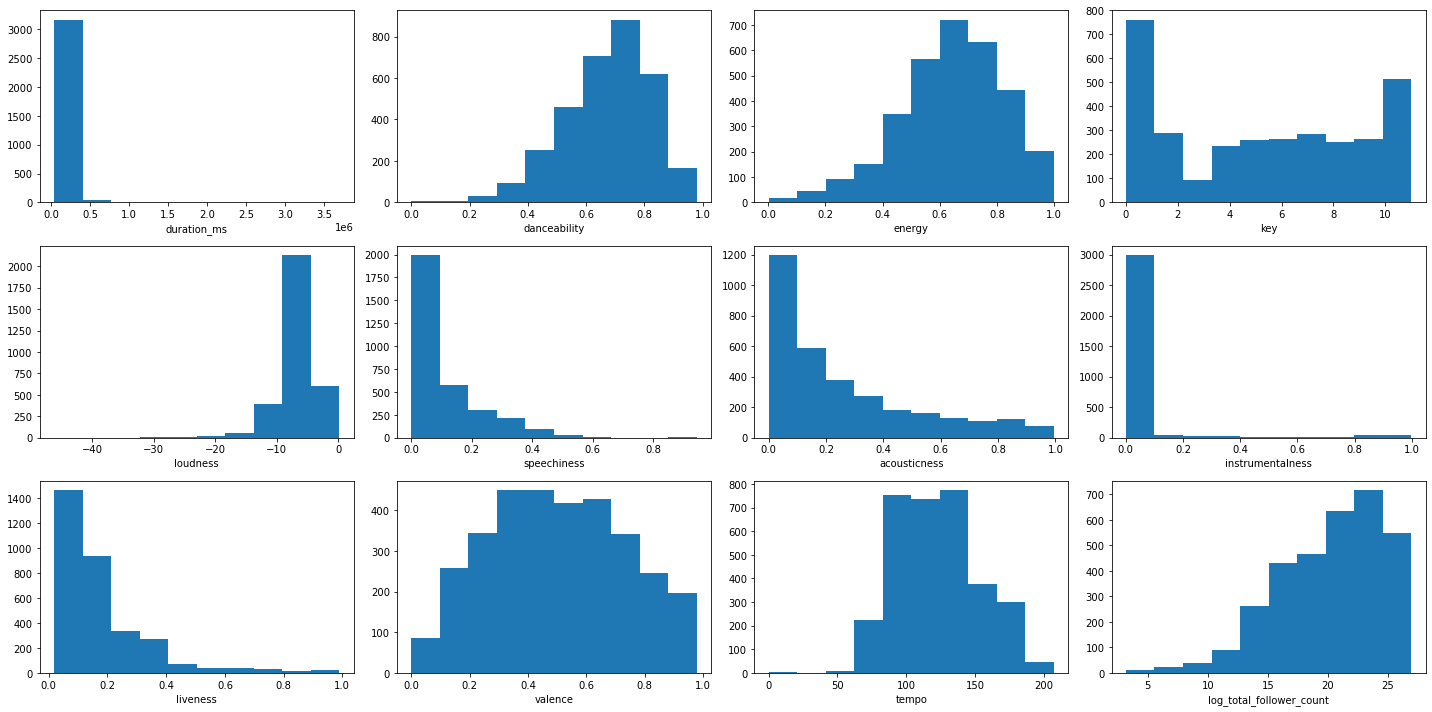

In [235]:
columns = ['duration_ms', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'log_total_follower_count']
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20,10))
for idx, ax in enumerate(axes.flatten()):
    # plot histogram
    ax.hist(df_train[columns[idx]])
    # set xlabel
    ax.set_xlabel(columns[idx])
plt.tight_layout()

#### ``Logistical Regression w/ Multiple Features``

In [408]:
# tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers

def build_model(num_features, hidden_layer_sizes=[], activation='relu', optimizer='SGD', learning_rate=0.01):
    """Return a simple logistic regression model using the Keras Sequential API."""
  # Clear session and set a random seed for consistent behavior.
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    

  # Use Keras Sequential API to build a logistic regression
    model = keras.Sequential()
    
    # create input layer
    model.add(tf.keras.Input(shape=(num_features,),
         name='Input'
    ))
    
    for hidden_layer_size in hidden_layer_sizes:
        model.add(tf.keras.layers.Dense(units=hidden_layer_size,
                                    activation=activation))
    
    model.add(keras.layers.Dense(
        units=1,  
        use_bias=True,
        activation='sigmoid',
        #kernel_initializer='random_normal',
        #bias_initializer='zeros'
        kernel_initializer=initializers.RandomNormal(stddev=0.01),
        bias_initializer=initializers.RandomNormal(stddev=0.01),
        name="Output"
    ))
  

    if optimizer == 'SGD':
        optimizer_select = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'Adam':
        optimizer_select = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        
  # Use Binary Crossentropy as our loss and the SGD optimizer.
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=optimizer_select,
        metrics=[tf.keras.metrics.BinaryAccuracy()]
    )
    
    return model

# Build a model
model = build_model(50, hidden_layer_sizes=[30], activation='relu', optimizer='Adam', learning_rate=0.01)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                1530      
                                                                 
 Output (Dense)              (None, 1)                 31        
                                                                 
Total params: 1,561
Trainable params: 1,561
Non-trainable params: 0
_________________________________________________________________


In [409]:
tf.random.set_seed(1234)
np.random.seed(1234)
# Train model
hist= model.fit(x=X_train_std,
                y=y_train,
                validation_data=[X_test_std, y_test],
                validation_split=0.1, # set 10% of train data for validation
                batch_size=len(X_train_std),
                epochs=40,
                verbose=1 #silence fit
)

Epoch 1/40
1/1 [==============================] - 0s 472ms/step - loss: 0.6924 - binary_accuracy: 0.5186 - val_loss: 0.6794 - val_binary_accuracy: 0.6572
Epoch 2/40
1/1 [==============================] - 0s 39ms/step - loss: 0.6808 - binary_accuracy: 0.6481 - val_loss: 0.6662 - val_binary_accuracy: 0.6913
Epoch 3/40
1/1 [==============================] - 0s 39ms/step - loss: 0.6685 - binary_accuracy: 0.6742 - val_loss: 0.6504 - val_binary_accuracy: 0.7341
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.6538 - binary_accuracy: 0.7155 - val_loss: 0.6321 - val_binary_accuracy: 0.7609
Epoch 5/40
1/1 [==============================] - 0s 36ms/step - loss: 0.6365 - binary_accuracy: 0.7419 - val_loss: 0.6118 - val_binary_accuracy: 0.7732
Epoch 6/40
1/1 [==============================] - 0s 30ms/step - loss: 0.6172 - binary_accuracy: 0.7512 - val_loss: 0.5903 - val_binary_accuracy: 0.7775
Epoch 7/40
1/1 [==============================] - 0s 31ms/step - loss: 0.5965 - b

In [284]:
y_train

array([0, 1, 1, ..., 1, 0, 1])

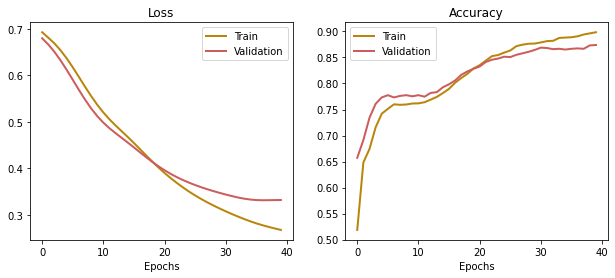

In [410]:
# grab history
history = hist.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history['val_binary_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy');

# plot decision boundaries for train data
# ax = fig.add_subplot(1, 3, 3)
# plot_decision_regions(X=X_train_std[['log_total_follower_count', 'valence']], y=y_train,
#                       clf=model)
# ax.set_xlabel('log_total_follower_count', size=10)
# ax.set_ylabel('valence', size=10)
# ax.set_title('Train data predictions');

In [411]:
# run the trained model on the test data (the model outputs probabilities)
y_train_pred_tf = model.predict(x=X_train_std).flatten()

# apply the threshold function to create a 0, 1 outcome
y_train_pred_tf = np.where(y_train_pred_tf>=0.5, 1, 0)
y_train_pred_tf

101/101 [==============================] - 0s 1ms/step


array([1, 0, 0, ..., 1, 0, 1])

In [412]:
# run the trained model on the test data (the model outputs probabilities)
y_test_pred_tf = model.predict(x=X_test_std).flatten()

# apply the threshold function to create a 0, 1 outcome
y_test_pred_tf = np.where(y_test_pred_tf>=0.5, 1, 0)
y_test_pred_tf

44/44 [==============================] - 0s 1ms/step


array([0, 1, 1, ..., 0, 1, 1])

In [413]:
conf_matrix = tf.math.confusion_matrix(
    y_test,
    y_test_pred_tf,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)
conf_matrix

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[596,  84],
       [ 90, 610]])>

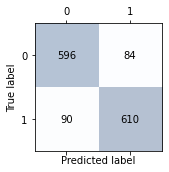

In [414]:
def confusion_matrix_plot(conf_matrix):
    """ Confusion matrix matplotlib plot
    # param conf_matrix: nested list of TP, TN, FP, FN
    # return: None
    """
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()

confusion_matrix_plot(conf_matrix.numpy())

In [415]:
# note that TensorFlow assumes that the positive class is cultivar 1
p = tf.keras.metrics.Precision(
    thresholds=None, top_k=None, class_id=None, name=None, dtype=None
)
p.update_state(y_test, y_test_pred_tf)  #18/(18+3)
print("Precision score: %3f" %p.result().numpy())

Precision score: 0.878963


In [416]:
# note that TensorFlow assumes that the positive class is cultivar 1
r = tf.keras.metrics.Recall(
    thresholds=None, top_k=None, class_id=None, name=None, dtype=None
)
r.update_state(y_test, y_test_pred_tf) #18/(18+1)
print("Recall score: %.3f" %r.result().numpy())

Recall score: 0.871


In [417]:
print("F1 score:",
    2*((p.result().numpy()*r.result().numpy())/(p.result().numpy()+r.result().numpy())))

F1 score: 0.8751792907714844


In [418]:
# Show learned model
w = model.layers[0].get_weights()[0]
b = model.layers[0].get_weights()[1]

print('Bias:', b)
print('Weights', w)

Bias: [0.34767509 0.23882012 0.2746381  0.3830349  0.32222113 0.09766287
 0.12665032 0.31411055 0.2751673  0.284432   0.3340367  0.2796952
 0.33356386 0.30905464 0.2741977  0.24823274 0.38995808 0.35535643
 0.32563937 0.25158492 0.36026806 0.34199128 0.30273482 0.20220177
 0.22876246 0.26829618 0.12748069 0.03198776 0.36804673 0.33371598]
Weights [[ 0.0734548  -0.16251299  0.01778984 ...  0.10769759  0.26624885
  -0.18964954]
 [-0.18931413 -0.11896624 -0.07777989 ... -0.10850409 -0.1401524
  -0.06975196]
 [-0.3343996  -0.39285898  0.38094872 ...  0.24892478  0.2254663
  -0.3808615 ]
 ...
 [-0.5668503   0.26664862 -0.16070834 ... -0.2642678   0.00559952
  -0.00811059]
 [ 0.4111486  -0.1292731  -0.10886006 ...  0.15168399 -0.327576
   0.1553699 ]
 [ 0.27610263  0.20744419 -0.01242709 ... -0.11454809 -0.5544901
  -0.15001987]]
